In [1]:
import warnings
warnings.filterwarnings('ignore')
import stwcs
import glob
import sys
import os
import shutil
import time
import filecmp
import astroquery
import progressbar
import copy
import requests
import random
import astropy.wcs as wcs
import numpy as np
from contextlib import contextmanager
from astropy import units as u
from astropy.utils.data import clear_download_cache,download_file
from astropy.io import fits
from astropy.table import Table, Column, unique
from astropy.time import Time
from astroscrappy import detect_cosmics
from stwcs import updatewcs
from scipy.interpolate import interp1d
import shapely
import pandas as pd

# Internal dependencies
from common import Constants
from common import Options
from common import Settings
from common import Util
from nbutils import get_filter, get_instrument, get_chip, get_filter, input_list
from nbutils import get_zpt, add_visit_info, organize_reduction_tables, pick_deepest_images

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

with suppress_stdout():
    from drizzlepac import tweakreg,astrodrizzle,catalogs,photeq
    from astroquery.mast import Observations
    from astropy.coordinates import SkyCoord

In [2]:
acceptable_filters = [
    'F220W','F250W','F330W','F344N','F435W','F475W','F550M','F555W',
    'F606W','F625W','F660N','F660N','F775W','F814W','F850LP','F892N',
    'F098M','F105W','F110W','F125W','F126N','F127M','F128N','F130N','F132N',
    'F139M','F140W','F153M','F160W','F164N','F167N','F200LP','F218W','F225W',
    'F275W','F280N','F300X','F336W','F343N','F350LP','F373N','F390M','F390W',
    'F395N','F410M','F438W','F467M','F469N','F475X','F487N','F547M',
    'F600LP','F621M','F625W','F631N','F645N','F656N','F657N','F658N','F665N',
    'F673N','F680N','F689M','F763M','F845M','F953N','F122M','F160BW','F185W',
    'F218W','F255W','F300W','F375N','F380W','F390N','F437N','F439W','F450W',
    'F569W','F588N','F622W','F631N','F673N','F675W','F702W','F785LP','F791W',
    'F953N','F1042M']

### HST

In [91]:
from astroquery.vizier import Vizier
vizier = Vizier(columns=['logD25'])

In [92]:
def query_hst(coord, vizier_radius = 5*u.arcsec, vizier_cat = "VII/237/pgc"):
    ra, dec = coord.ra, coord.dec
    result_table = vizier.query_region(coord, radius=vizier_radius, catalog=vizier_cat)
    logd = result_table[0]['logD25'][0]
    query_radius = (10**logd * 0.1 * u.arcmin)

    obsTable = Observations.query_region(coord, radius=query_radius)
    obsTable = obsTable.filled()

    masks = []
    masks.append([t.upper()=='HST' for t in obsTable['obs_collection']])
    masks.append([p.upper()=='IMAGE' for p in obsTable['dataproduct_type']])
    masks.append([filt.upper() in ['F275W', 'F555W', 'F814W'] 
                  for filt in obsTable['filters']])
    # Added mask to remove calibration data from search
    masks.append([f.upper()!='DETECTION' for f in obsTable['filters']])
    masks.append([i.upper()!='CALIBRATION' for i in obsTable['intentType']])
    masks.append([r.upper()=='PUBLIC' for r in obsTable['dataRights']])

    mask = [all(l) for l in list(map(list, zip(*masks)))]
    obsTable = obsTable[mask]
    obsTable.sort('t_min')

    return obsTable

In [103]:
def query_jwst(coord, vizier_radius = 5*u.arcsec, vizier_cat = "VII/237/pgc"):
    ra, dec = coord.ra, coord.dec
    result_table = vizier.query_region(coord, radius=vizier_radius, catalog=vizier_cat)
    logd = result_table[0]['logD25'][0]
    query_radius = (10**logd * 0.1 * u.arcmin)

    obsTable = Observations.query_region(coord, radius=max(5*u.arcmin, query_radius))
    obsTable = obsTable.filled()
    
    masks = []
    masks.append([t.upper()=='JWST' for t in obsTable['obs_collection']]) #JWST images
    masks.append([any(l) for l in list(map(list,zip(*[[det in inst.upper() #NIRCAM images
                for inst in obsTable['instrument_name']]
                for det in ['NIRCAM']])))])
    
    masks.append([f.upper()!='DETECTION' for f in obsTable['filters']])
    masks.append([i.upper()!='CALIBRATION' for i in obsTable['intentType']])
    masks.append([d.upper()=='PUBLIC' for d in obsTable['dataRights']])
    
    mask = [all(l) for l in list(map(list, zip(*masks)))]
    obsTable_webb = obsTable[mask]
    obsTable_webb.sort('t_min')

    return obsTable_webb

In [107]:
# ra, dec = 31.4625, -58.49072
ra, dec =  5.6095, -53.6479
radius = 5*u.arcmin

In [8]:
obsTable = Observations.query_region(coord, radius=radius)

In [ ]:
obsTable = obsTable.filled()

In [ ]:
masks = []
masks.append([t.upper()=='HST' for t in obsTable['obs_collection']])
masks.append([p.upper()=='IMAGE' for p in obsTable['dataproduct_type']])
masks.append([any(l) for l in list(map(list,zip(*[[det in inst.upper()
            for inst in obsTable['instrument_name']]
            for det in ['ACS','WFC','WFPC2']])))])
# Added mask to remove calibration data from search
masks.append([f.upper()!='DETECTION' for f in obsTable['filters']])
masks.append([i.upper()!='CALIBRATION' for i in obsTable['intentType']])

In [7]:
mask = [all(l) for l in list(map(list, zip(*masks)))]
obsTable = obsTable[mask]

In [8]:
obsTable.sort('t_min')

In [21]:
obsTable_ = obsTable[obsTable['instrument_name'] == 'WFC3/IR'][:6] #obsTable[5:15]

In [22]:
obsTable_

<Table length=6>
intentType obs_collection provenance_name ...  srcDen  obsid   distance
  str11        str11           str17      ... float64   str9   float64 
---------- -------------- --------------- ... ------- -------- --------
   science            HST          CALWF3 ...     nan 24815204      0.0
   science            HST         HAP-MVM ...     nan 84761045      0.0
   science            HST         HAP-SVM ...     nan 26617779      0.0
   science            HST         HAP-MVM ...     nan 84761053      0.0
   science            HST          CALWF3 ...     nan 24815205      0.0
   science            HST         HAP-MVM ...     nan 84851267      0.0

In [23]:
productlist = None

#### All products for single observation

In [15]:
obs = obsTable_[0]

In [16]:
prlst = Observations.get_product_list(obs)

In [17]:
prlst

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9
23956103,HST,image,icn105dvq,DADS FLT_HLET,S,mast:HST/product/icn105dvq_flt_hlet.fits,AUXILIARY,--,FLT_HLET,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt_hlet.fits,8640,24815204,PUBLIC,2,F140W
23956103,HST,image,icn105dvq,Preview-Full,S,mast:HST/product/icn105dvq_flt.jpg,PREVIEW,--,--,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.jpg,210263,24815204,PUBLIC,2,F140W
23956103,HST,image,icn105dvq,DADS LOG file,S,mast:HST/product/icn105dvq_log.txt,INFO,--,LOG,--,CALWF3,--,13677,icn105dvq_log.txt,7348,24815204,PUBLIC,1,F140W
23956103,HST,image,icn105dvq,DADS SPT file - Engineering telemetry ACS/WFC3/NICMOS/COS/STIS,S,mast:HST/product/icn105dvq_spt.fits,AUXILIARY,--,SPT,--,CALWF3,--,13677,icn105dvq_spt.fits,852480,24815204,PUBLIC,1,F140W
23956103,HST,image,icn105dvq,Preview-Full,S,mast:HST/product/icn105dvq_raw.jpg,PREVIEW,--,--,--,CALWF3,--,13677,icn105dvq_raw.jpg,248097,24815204,PUBLIC,1,F140W
23956103,HST,image,icn105dvq,DADS TRL file - Processing log,S,mast:HST/product/icn105dvq_trl.fits,AUXILIARY,--,TRL,--,CALWF3,--,13677,icn105dvq_trl.fits,25920,24815204,PUBLIC,1,F140W
23956103,HST,image,icn105dvq,DADS IMA file - Intermediate Mult-Accum WFC3/NICMOS,S,mast:HST/product/icn105dvq_ima.fits,AUXILIARY,--,IMA,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_ima.fits,115686720,24815204,PUBLIC,2,F140W
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W
23956103,HST,image,icn105dvq,DADS RAW file - Raw exposure COS/NICMOS/STIS/WFC3/ACS,S,mast:HST/product/icn105dvq_raw.fits,SCIENCE,--,RAW,--,CALWF3,--,13677,icn105dvq_raw.fits,23400000,24815204,PUBLIC,1,F140W


In [18]:
splt = [prod.split('_')[-1] for prod in prlst['productFilename']]

In [19]:
np.unique(np.array(splt))

array(['asn.fits', 'color.jpg', 'drz.fits', 'drz.jpg', 'flt.fits',
       'flt.jpg', 'hlet.fits', 'ima.fits', 'jif.fits', 'jit.fits',
       'log.txt', 'point-cat.ecsv', 'raw.fits', 'raw.jpg',
       'segment-cat.ecsv', 'spt.fits', 'trl.fits', 'trl.txt'],
      dtype='<U16')

In [20]:
pmask = [('drz.fits' in prod) | ('drc.fits' in prod) | ('flt.fits' in prod) for prod in prlst['productFilename']]

In [21]:
prlst[pmask]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,24815204,PUBLIC,2,F140W
24815204,HST,image,icn105010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/icn105010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105010_drz.fits,13311360,24815204,PUBLIC,3,F140W
26617076,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dv,HAP flat-field product,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dv_flt.fits,SCIENCE,--,FLT,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dv_flt.fits,16646400,24815204,PUBLIC,2,F140W
26617076,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dv,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dv_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dv_drz.fits,23279040,24815204,PUBLIC,2,F140W
26617135,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dw,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dw_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dw_drz.fits,23279040,24815204,PUBLIC,2,F140W
26617135,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dw,HAP flat-field product,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dw_flt.fits,SCIENCE,--,FLT,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dw_flt.fits,16646400,24815204,PUBLIC,2,F140W
26617277,HST,image,hst_13677_05_wfc3_ir_total_icn105,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_total_icn105_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_total_icn105_drz.fits,23302080,24815204,PUBLIC,3,detection
26617779,HST,image,hst_13677_05_wfc3_ir_f140w_icn105,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105_drz.fits,23284800,24815204,PUBLIC,3,F140W


In [22]:
productlist = prlst[pmask]

In [23]:
downloadFilenames = []
for prod in productlist:
    filename = prod['productFilename']

    # Cut down new HST filenames that start with hst_PROGID
    filename = '_'.join(filename.split('_')[-2:])
    downloadFilenames.append(filename)

productlist.add_column(Column(downloadFilenames, name='downloadFilename'))

# Check that all files to download are unique
if productlist and len(productlist)>1:
    productlist = unique(productlist, keys='downloadFilename')

# Sort by obsID in case we need to reference
productlist.sort('obsID')

In [24]:
productlist

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters,downloadFilename
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9,str18
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W,icn105dvq_flt.fits
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,24815204,PUBLIC,2,F140W,icn105dwq_flt.fits
24815204,HST,image,icn105010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/icn105010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105010_drz.fits,13311360,24815204,PUBLIC,3,F140W,icn105010_drz.fits
26617076,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dv,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dv_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dv_drz.fits,23279040,24815204,PUBLIC,2,F140W,icn105dv_drz.fits
26617076,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dv,HAP flat-field product,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dv_flt.fits,SCIENCE,--,FLT,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dv_flt.fits,16646400,24815204,PUBLIC,2,F140W,icn105dv_flt.fits
26617135,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dw,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dw_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dw_drz.fits,23279040,24815204,PUBLIC,2,F140W,icn105dw_drz.fits
26617135,HST,image,hst_13677_05_wfc3_ir_f140w_icn105dw,HAP flat-field product,D,mast:HST/product/hst_13677_05_wfc3_ir_f140w_icn105dw_flt.fits,SCIENCE,--,FLT,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_f140w_icn105dw_flt.fits,16646400,24815204,PUBLIC,2,F140W,icn105dw_flt.fits
26617277,HST,image,hst_13677_05_wfc3_ir_total_icn105,HAP fits science image,D,mast:HST/product/hst_13677_05_wfc3_ir_total_icn105_drz.fits,SCIENCE,--,DRZ,--,HAP-SVM,DrizzlePac 3.6.2,13677,hst_13677_05_wfc3_ir_total_icn105_drz.fits,23302080,24815204,PUBLIC,3,detection,icn105_drz.fits


#### general productlist for all observations

In [19]:
obs = obsTable_

In [24]:
for i, obs in enumerate(obsTable_):
    try:
        productList = Observations.get_product_list(obs)
        # Ignore the 'C' type products
        mask = productList['type']=='S'
        productList = productList[mask]
    except:
        error = 'ERROR: MAST is not working currently working\n'
        error += 'Try again later...'
        print(error)
    #         return(productlist)

    instrument = obs['instrument_name']
    s_ra = obs['s_ra']
    s_dec = obs['s_dec']

    instcol = Column([instrument]*len(productList), name='instrument_name')
    racol = Column([s_ra]*len(productList), name='ra')
    deccol = Column([s_dec]*len(productList), name='dec')

    productList.add_column(instcol)
    productList.add_column(racol)
    productList.add_column(deccol)

    for prod in productList:
        filename = prod['productFilename']

        if (('c0m.fits' in filename and 'WFPC2' in instrument) or
            ('c1m.fits' in filename and 'WFPC2' in instrument) or
            ('c0m.fits' in filename and 'PC/WFC' in instrument) or
            ('c1m.fits' in filename and 'PC/WFC' in instrument) or
            ('flc.fits' in filename and 'ACS/WFC' in instrument) or
            ('flt.fits' in filename and 'ACS/HRC' in instrument) or
            ('flc.fits' in filename and 'WFC3/UVIS' in instrument) or
            ('flt.fits' in filename and 'WFC3/IR' in instrument)):

            if not productlist:
                productlist = Table(prod)
            else:
                productlist.add_row(prod)

In [25]:
productlist

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters,instrument_name,ra,dec
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9,str7,float64,float64
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W,WFC3/IR,31.44337834647,-58.48585330631
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,24815204,PUBLIC,2,F140W,WFC3/IR,31.44337834647,-58.48585330631
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,26617779,PUBLIC,2,F140W,WFC3/IR,31.4428,-58.4852
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,26617779,PUBLIC,2,F140W,WFC3/IR,31.4428,-58.4852
23956105,HST,image,icn105dyq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dyq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dyq_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631
23956106,HST,image,icn105e0q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e0q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e0q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631
23956107,HST,image,icn105e2q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e2q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e2q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631
23956108,HST,image,icn105e3q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e3q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e3q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631


In [26]:
downloadFilenames = []
for prod in productlist:
    filename = prod['productFilename']

    # Cut down new HST filenames that start with hst_PROGID
    filename = '_'.join(filename.split('_')[-2:])
    downloadFilenames.append(filename)

productlist.add_column(Column(downloadFilenames, name='downloadFilename'))

# Check that all files to download are unique
if productlist and len(productlist)>1:
    productlist = unique(productlist, keys='downloadFilename')

# Sort by obsID in case we need to reference
productlist.sort('obsID')

In [27]:
productlist

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters,instrument_name,ra,dec,downloadFilename
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str7,str19,str5,str50,int64,str8,str6,int64,str9,str7,float64,float64,str18
23956103,HST,image,icn105dvq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dvq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dvq_flt.fits,16634880,24815204,PUBLIC,2,F140W,WFC3/IR,31.44337834647,-58.48585330631,icn105dvq_flt.fits
23956104,HST,image,icn105dwq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dwq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dwq_flt.fits,16634880,24815204,PUBLIC,2,F140W,WFC3/IR,31.44337834647,-58.48585330631,icn105dwq_flt.fits
23956105,HST,image,icn105dyq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105dyq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105dyq_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631,icn105dyq_flt.fits
23956106,HST,image,icn105e0q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e0q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e0q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631,icn105e0q_flt.fits
23956107,HST,image,icn105e2q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e2q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e2q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631,icn105e2q_flt.fits
23956108,HST,image,icn105e3q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icn105e3q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13677,icn105e3q_flt.fits,16634880,24815205,PUBLIC,2,F105W,WFC3/IR,31.44337834647,-58.48585330631,icn105e3q_flt.fits


In [28]:
Observations.download_products(productlist, extension='fits')

Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/icn105dvq/icn105dvq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105dwq/icn105dwq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105dyq/icn105dyq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105e0q/icn105e0q_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105e2q/icn105e2q_flt.fits,COMPLETE,None,None
./mastDownload/HST/icn105e3q/icn105e3q_flt.fits,COMPLETE,None,None


### JWST

In [3]:
#images for M92
# ra, dec = 259.2800254, 43.13566 
#images for NGC0628
# ra, dec = 24.174049, 15.78346
#images for SN2024aecx
# ra, dec = 166.4564675, -0.034845
#images for NGC0300
# ra, dec = 13.723, -37.68486
# images for NGC 4038
# ra, dec = 218.17, -44.17448
# images for NGC 4141
ra, dec = "12:09:44.3100", "+58:50:56.70"
#long wavelength image for gaia test
# ra, dec = 288.180264431434, -2.33687287711816
coord = SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))
radius = 5*u.arcmin

In [4]:
coord

<SkyCoord (ICRS): (ra, dec) in deg
    (182.434625, 58.84908333)>

In [5]:
obsTable = Observations.query_region(coord, radius=radius)

In [6]:
obsTable = obsTable.filled()

In [7]:
#obsTable masks
masks = []
masks.append([t.upper()=='JWST' for t in obsTable['obs_collection']]) #JWST images
masks.append([any(l) for l in list(map(list,zip(*[[det in inst.upper() #NIRCAM images
            for inst in obsTable['instrument_name']]
            for det in ['NIRCAM']])))])

#add mask to remove entries with 1. null jpegURL/dataURL 2. private data rights(?)
# Added mask to remove calibration data from separch
masks.append([f.upper()!='DETECTION' for f in obsTable['filters']])
masks.append([i.upper()!='CALIBRATION' for i in obsTable['intentType']])
masks.append([d.upper()=='PUBLIC' for d in obsTable['dataRights']])

mask = [all(l) for l in list(map(list, zip(*masks)))]
obsTable_webb = obsTable[mask]

In [8]:
obsTable_webb[obsTable_webb['calib_level'] == 3]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str11,str12,str12,str4,str6,str16,str20,str27,str65,float64,float64,str10,str19,int64,float64,float64,float64,float64,float64,str59,float64,str23,str7,int64,str133,str120,str137,str6,bool,float64,str9,float64
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F150W2,INFRARED,FRB20250316A,Unidentified; Radio sources,jw09331-o001_t001_nircam_clear-f150w2,182.434625,58.84908333333333,image,"Blanchard, Peter",3,60814.58034247419,60814.698149375,9469.826999999997,1007.9999999999999,2334.0,A Deep Search for a Counterpart to the Nearby FRB 20250316A,60815.1519675,9331,DD,999999,POLYGON 182.404979659 58.87407975 182.45917709 58.849972872 182.412370513 58.821816664 182.358184591 58.845903945,mast:JWST/product/jw09331-o001_t001_nircam_clear-f150w2_i2d.jpg,mast:JWST/product/jw09331-o001_t001_nircam_clear-f150w2_i2d.fits,PUBLIC,False,nan,266332306,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F322W2,INFRARED,FRB20250316A,Unidentified; Radio sources,jw09331-o001_t001_nircam_clear-f322w2,182.434625,58.84908333333333,image,"Blanchard, Peter",3,60814.58034247419,60814.69814862269,9469.826999999997,2430.0,4013.0000000000005,A Deep Search for a Counterpart to the Nearby FRB 20250316A,60815.1519675,9331,DD,999999,POLYGON 182.405166703 58.87380317 182.458637825 58.850306469 182.413074151 58.822563683 182.359614976 58.846041564,mast:JWST/product/jw09331-o001_t001_nircam_clear-f322w2_i2d.jpg,mast:JWST/product/jw09331-o001_t001_nircam_clear-f322w2_i2d.fits,PUBLIC,False,nan,266332301,0.0


In [9]:
obsTable_webb

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str11,str12,str12,str4,str13,str16,str20,str27,str65,float64,float64,str10,str19,int64,float64,float64,float64,float64,float64,str59,float64,str23,str7,int64,str133,str120,str137,str6,bool,float64,str9,float64
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F150W2,INFRARED,FRB20250316A,Unidentified; Radio sources,jw09331-o001_t001_nircam_clear-f150w2,182.434625,58.84908333333333,image,"Blanchard, Peter",3,60814.58034247419,60814.698149375,9469.826999999997,1007.9999999999999,2334.0,A Deep Search for a Counterpart to the Nearby FRB 20250316A,60815.1519675,9331,DD,999999,POLYGON 182.404979659 58.87407975 182.45917709 58.849972872 182.412370513 58.821816664 182.358184591 58.845903945,mast:JWST/product/jw09331-o001_t001_nircam_clear-f150w2_i2d.jpg,mast:JWST/product/jw09331-o001_t001_nircam_clear-f150w2_i2d.fits,PUBLIC,False,nan,266332306,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F322W2,INFRARED,FRB20250316A,Unidentified; Radio sources,jw09331-o001_t001_nircam_clear-f322w2,182.434625,58.84908333333333,image,"Blanchard, Peter",3,60814.58034247419,60814.69814862269,9469.826999999997,2430.0,4013.0000000000005,A Deep Search for a Counterpart to the Nearby FRB 20250316A,60815.1519675,9331,DD,999999,POLYGON 182.405166703 58.87380317 182.458637825 58.850306469 182.413074151 58.822563683 182.359614976 58.846041564,mast:JWST/product/jw09331-o001_t001_nircam_clear-f322w2_i2d.jpg,mast:JWST/product/jw09331-o001_t001_nircam_clear-f322w2_i2d.fits,PUBLIC,False,nan,266332301,0.0
science,JWST,APT,NIRCAM/IMAGE,JWST,F150W2;F322W2,INFRARED,FRB20250316A,N/A,jw09331001001_xx101_00001_nircam,182.434625,58.84908333333333,image,"Blanchard, Peter",-1,nan,nan,1052.203,1007.9999999999999,4013.0000000000005,A Deep Search for a Counterpart to the Nearby FRB 20250316A,nan,9331,DD,1,POLYGON 182.488545869 58.82120938388 182.41697447556 58.82145676031 182.41788359333 58.85788526259 182.48780538354 58.85794426319,N/A,N/A,PUBLIC,False,nan,262854696,0.0
science,JWST,APT,NIRCAM/IMAGE,JWST,F150W2;F322W2,INFRARED,FRB20250316A,N/A,jw09331001001_xx102_00002_nircam,182.434625,58.84908333333333,image,"Blanchard, Peter",-1,nan,nan,1052.203,1007.9999999999999,4013.0000000000005,A Deep Search for a Counterpart to the Nearby FRB 20250316A,nan,9331,DD,2,POLYGON 182.4885619518 58.82117303614 182.41699063352 58.82142042149 182.41789976734 58.85784892366 182.48782148418 58.85790791554,N/A,N/A,PUBLIC,False,nan,262854697,0.0
science,JWST,APT,NIRCAM/IMAGE,JWST,F150W2;F322W2,INFRARED,FRB20250316A,N/A,jw09331001001_xx103_00003_nircam,182.434625,58.84908333333333,image,"Blanchard, Peter",-1,nan,nan,1052.203,1007.9999999999999,4013.0000000000005,A Deep Search for a Counterpart to the Nearby FRB 20250316A,nan,9331,DD,3,POLYGON 182.48857795316 58.82112835512 182.41700672725 58.82137574936 182.41791587682 58.85780425141 182.48783750347 58.85786323461,N/A,N/A,PUBLIC,False,nan,262854698,0.0
science,JWST,APT,NIRCAM/IMAGE,JWST,F150W2;F322W2,INFRARED,FRB20250316A,N/A,jw09331001001_xx104_00004_nircam,182.434625,58.84908333333333,image,"Blanchard, Peter",-1,nan,nan,1052.203,1007.9999999999999,4013.0000000000005,A Deep Search for a Counterpart to the Nearby FRB 20250316A,nan,9331,DD,4,POLYGON 182.4885997901 58.82119258572 182.4170284317 58.821439992 182.4179376058 58.8578684939 182.48785936221 58.85792746533,N/A,N/A,PUBLIC,False,nan,262854699,0.0
science,JWST,APT,NIRCAM/IMAGE,JWST,F150W2;F322W2,INFRARED,FRB20250316A,N/A,jw09331001001_xx105_00005_nircam,182.434625,58.84908333333333,image,"Blanchard, Peter",-1,nan,nan,1052.203,1007.9999999999999,4013.0000000000005,A Deep Search for a Counterpart to the Nearby FRB 20250316A,nan,9331,DD,5,POLYGON 182.48863205091

In [13]:
obsTable_webb['s_region'][0]

'POLYGON 218.143363978 -44.105635278 218.20926502 -44.106730006 218.205000346 -44.241124709 218.138949032 -44.240027484'

In [14]:
pgons, filt = [], []
for i in range(len(obsTable_webb)):
    region = obsTable_webb['s_region'][i]
    coords = np.array(region.split('POLYGON ')[1].split(' '), dtype = float)
    pgons.append(shapely.Polygon(coords.reshape(4, 2)))
    filt.append(obsTable_webb['filters'][i])

In [15]:
np.unique(np.array(filt))

array(['F090W', 'F115W', 'F150W', 'F150W2;F164N', 'F187N', 'F200W',
       'F212N', 'F277W', 'F300M', 'F335M', 'F356W', 'F360M', 'F444W',
       'F444W;F405N'], dtype='<U12')

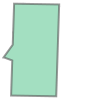

In [16]:
net_field = shapely.unary_union(pgons)
net_field

In [17]:
filters = ['F090W', 'F115W', 'F150W', 'F200W']
# filters = ['F115W;F356W', 'F200W;F444W']
mask = [np.array(i) in filters for i in filt]

In [18]:
f277_obs = np.array(pgons)[mask] #[np.array(filt) == 'F182M']

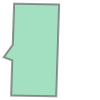

In [19]:
f277_field = shapely.unary_union(f277_obs)
f277_field

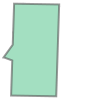

In [20]:
net_field

In [21]:
shapely.intersection(f277_field, net_field).area/net_field.area

0.999896298496657

In [ ]:
productList_0 = Observations.get_product_list(obsTable_webb[0])

In [55]:
productList_0

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str5,str36,str64,str1,str69,str9,str28,str11,str1,str7,str6,str4,str51,int64,str9,str6,int64,str5
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS1 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq1_2023147081405_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,1995,jw01995019001_gs-acq1_2023147081405_stream.fits,406080,140242399,PUBLIC,1,F356W
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS1 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq1_2023147081405_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,1995,jw01995019001_gs-acq1_2023147081405_uncal.fits,420480,140242399,PUBLIC,1,F356W
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS1 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq1_2023147081452_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,1995,jw01995019001_gs-acq1_2023147081452_stream.fits,406080,140242399,PUBLIC,1,F356W
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS1 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq1_2023147081452_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,1995,jw01995019001_gs-acq1_2023147081452_uncal.fits,420480,140242399,PUBLIC,1,F356W
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS1 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq1_2023147081405_cal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,1.16.1,1995,jw01995019001_gs-acq1_2023147081405_cal.fits,1284480,140242399,PUBLIC,2,F356W
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS1 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq1_2023147081452_cal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,1.16.1,1995,jw01995019001_gs-acq1_2023147081452_cal.fits,1284480,140242399,PUBLIC,2,F356W
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS2 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq2_2023147081406_stream.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,1995,jw01995019001_gs-acq2_2023147081406_stream.fits,34560,140242399,PUBLIC,1,F356W
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS2 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq2_2023147081406_uncal.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,1995,jw01995019001_gs-acq2_2023147081406_uncal.fits,48960,140242399,PUBLIC,1,F356W
140242323,JWST,image,jw01995019001_02101_00006_nrcblong,FGS2 guide star acquisition,S,mast:JWST/product/jw01995019001_gs-acq2_2023147081454_stream.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,1995,jw01995019001_gs-acq2_2023147081454_stream.fits,34560,140242399,PUBLIC,1,F356W


In [56]:
productList = productList_0
stage = 3

In [57]:
#product list masks
productmasks = []
productmasks.append([p.upper() == 'SCIENCE' for p in productList['productType']])
if stage == 2:
    productmasks.append([t == 'CAL' for t in productList['productSubGroupDescription']])
    productmasks.append([c == 2 for c in productList['calib_level']])
if stage == 3:
    productmasks.append([t == 'I2D' for t in productList['productSubGroupDescription']])
    productmasks.append([c == 3 for c in productList['calib_level']])


productmask = [all(l) for l in list(map(list, zip(*productmasks)))]
productList = productList[productmask]

In [58]:
productList

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str5,str36,str64,str1,str69,str9,str28,str11,str1,str7,str6,str4,str51,int64,str9,str6,int64,str5
140242399,JWST,image,jw01995-o019_t019_nircam_clear-f356w,exposure/target (L2b/L3): rectified 2D image,D,mast:JWST/product/jw01995-o019_t019_nircam_clear-f356w_i2d.fits,SCIENCE,Minimum Recommended Products,I2D,--,CALJWST,1.16.1,1995,jw01995-o019_t019_nircam_clear-f356w_i2d.fits,308266560,140242399,PUBLIC,3,F356W


In [59]:
Observations.download_products(productList, extension='fits')

Local Path,Status,Message,URL
str102,str8,object,object
./mastDownload/JWST/jw01995-o019_t019_nircam_clear-f356w/jw01995-o019_t019_nircam_clear-f356w_i2d.fits,COMPLETE,None,None
